/Users/yuchiaol_ntuas/miniconda3/lib/python3.11/site-packages/xarray/coding/times.py:170: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/Users/yuchiaol_ntuas/miniconda3/lib/python3.11/site-packages/xarray/coding/times.py:995: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/yuchiaol_ntuas/miniconda3/lib/python3.11/site-packages/xarray/core/indexing.py:630: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.dateti

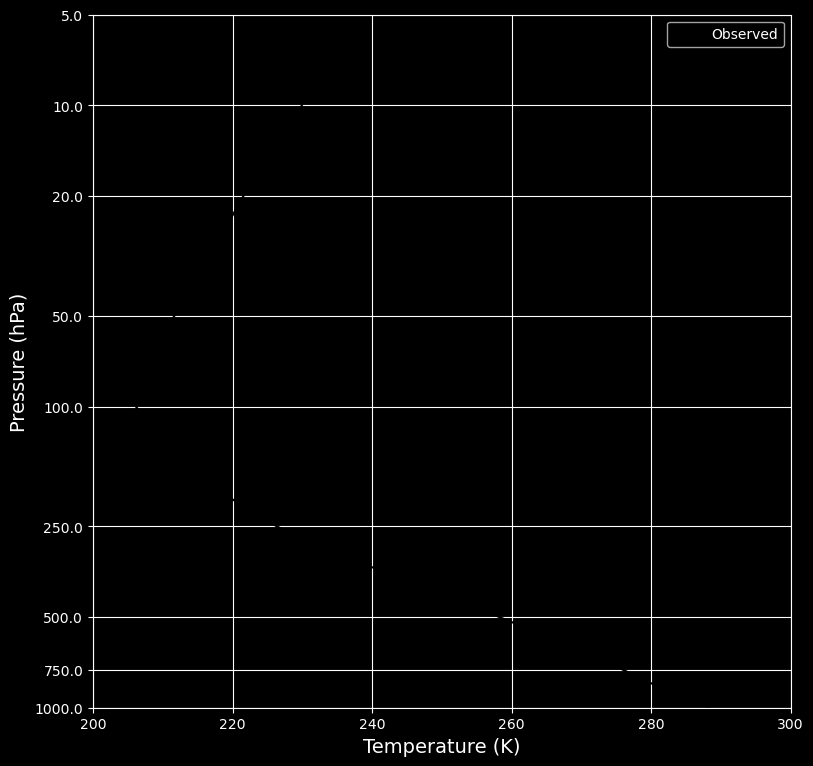

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import climlab
from scipy.optimize import brentq

plt.style.use('dark_background')

# read data from ncep reanalysis data
url = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/Reanalysis_Data/NCEP/NCEP/clima/pressure/air'
air = xr.open_dataset(url)
# The name of the vertical axis is different than the NOAA ESRL version..
ncep_air = air.rename({'lev': 'level'})
ncep_air

#  Take global, annual average and convert to Kelvin
weight = np.cos(np.deg2rad(ncep_air.lat)) / np.cos(np.deg2rad(ncep_air.lat)).mean(dim='lat')
Tglobal = (ncep_air.air * weight).mean(dim=('lat','lon','time'))
Tglobal += climlab.constants.tempCtoK
Tglobal


#  A handy re-usable routine for making a plot of the temperature profiles
#  We will plot temperatures with respect to log(pressure) to get a height-like coordinate

def zstar(lev):
    return -np.log(lev / climlab.constants.ps)

def plot_soundings(result_list, name_list, plot_obs=True, fixed_range=True):
    color_cycle=['r', 'g', 'b', 'y']
    # col is either a column model object or a list of column model objects
    #if isinstance(state_list, climlab.Process):
    #    # make a list with a single item
    #    collist = [collist]
    fig, ax = plt.subplots(figsize=(9,9))
    if plot_obs:
        ax.plot(Tglobal, zstar(Tglobal.level), color='k', label='Observed')    
    for i, state in enumerate(result_list):
        Tatm = state['Tatm']
        lev = Tatm.domain.axes['lev'].points
        Ts = state['Ts']
        ax.plot(Tatm, zstar(lev), color=color_cycle[i], label=name_list[i])
        ax.plot(Ts, 0, 'o', markersize=12, color=color_cycle[i])
    #ax.invert_yaxis()
    yticks = np.array([1000., 750., 500., 250., 100., 50., 20., 10., 5.])
    ax.set_yticks(-np.log(yticks/1000.))
    ax.set_yticklabels(yticks)
    ax.set_xlabel('Temperature (K)', fontsize=14)
    ax.set_ylabel('Pressure (hPa)', fontsize=14)
    ax.grid()
    ax.legend()
    if fixed_range:
        ax.set_xlim([200, 300])
        ax.set_ylim(zstar(np.array([1000., 5.])))
    #ax2 = ax.twinx()
    
    return ax

plot_soundings([],[] );


climlab Process of type <class 'climlab.model.column.GreyRadiationModel'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (30,) 
The subprocess tree: 
Untitled: <class 'climlab.model.column.GreyRadiationModel'>
   LW: <class 'climlab.radiation.greygas.GreyGas'>
   SW: <class 'climlab.radiation.greygas.GreyGasSW'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>

0.053690752586678596


array([238.5])

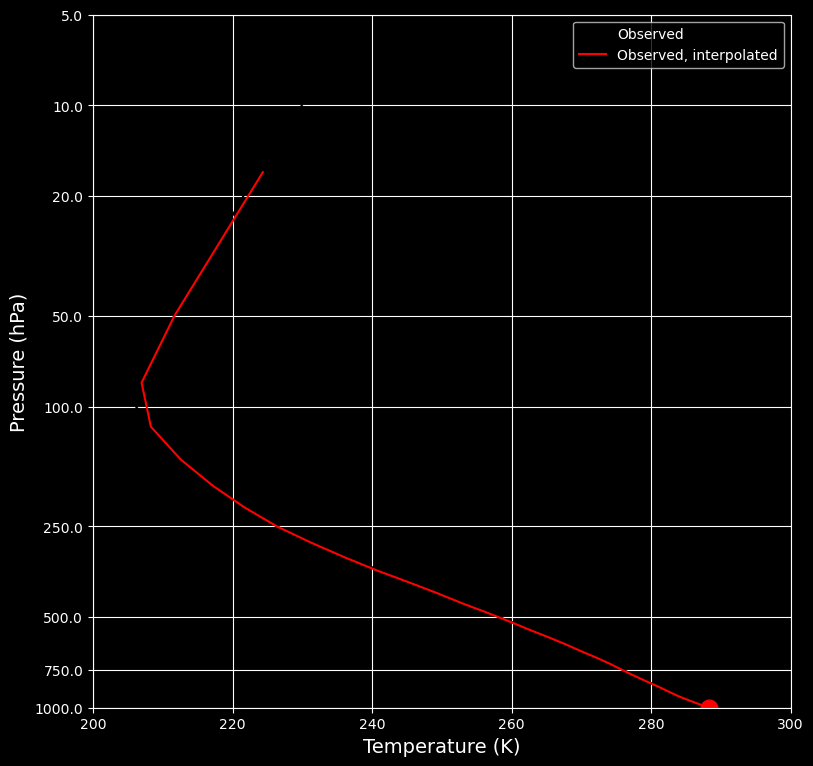

In [2]:
#  initialize a grey radiation model with 30 levels
col = climlab.GreyRadiationModel()
print(col)

# interpolate to 30 evenly spaced pressure levels
lev = col.lev
Tinterp = np.interp(lev, np.flipud(Tglobal.level), np.flipud(Tglobal))
Tinterp
#  Need to 'flipud' because the interpolation routine 
#  needs the pressure data to be in increasing order

# Initialize model with observed temperatures
col.Ts[:] = Tglobal[0]
col.Tatm[:] = Tinterp

# This should look just like the observations
result_list = [col.state]
name_list = ['Observed, interpolated']
plot_soundings(result_list, name_list);

col.compute_diagnostics()
col.OLR

# Need to tune absorptivity to get OLR = 238.5
epsarray = np.linspace(0.01, 0.1, 100)
OLRarray = np.zeros_like(epsarray)

for i in range(epsarray.size):
    col.subprocess['LW'].absorptivity = epsarray[i]
    col.compute_diagnostics()
    OLRarray[i] = col.OLR

def OLRanom(eps):
    col.subprocess['LW'].absorptivity = eps
    col.compute_diagnostics()
    return col.OLR - 238.5

# Use numerical root-finding to get the equilibria
# brentq is a root-finding function
#  Need to give it a function and two end-points
#  It will look for a zero of the function between those end-points
eps = brentq(OLRanom, 0.01, 0.1)
print( eps)

col.subprocess.LW.absorptivity = eps
col.subprocess.LW.absorptivity

col.compute_diagnostics()
col.OLR
